<a href="https://colab.research.google.com/github/pandya6988/Text_summarization/blob/main/DCEC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pretraining 
First we need to pretrain our VAE for few epocs.

In [12]:
from tensorflow import keras
import tensorflow as tf
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt
from keras import layers
from sklearn import datasets
from sklearn.cluster import KMeans

**Loading data**

In [2]:
train, test = tf.keras.datasets.mnist.load_data()

**setting up x and y for autoencoder**

In [3]:
x = np.vstack((train[0], test[0]))
x = x[:,:,:, np.newaxis]
y = np.vstack((train[1].reshape(-1,1), test[1].reshape(-1,1)))

In [4]:
def CAE(input_shape=(28, 28, 1), filters=[32, 64, 128, 10]):
    model = keras.Sequential()
    if input_shape[0] % 8 == 0:
        pad3 = 'same'
    else:
        pad3 = 'valid'
    
    # Encoder
    model.add(layers.Conv2D(filters[0], 5, strides=2, padding='same', activation='relu', name='conv1', input_shape=input_shape))
    model.add(layers.Conv2D(filters[1], 5, strides=2, padding='same', activation='relu', name='conv2'))
    model.add(layers.Conv2D(filters[2], 3, strides=2, padding=pad3, activation='relu', name='conv3'))
    model.add(layers.Flatten())
    model.add(layers.Dense(units=filters[3], name='embedding'))

    # Decoder
    model.add(layers.Dense(units=filters[2]*int(input_shape[0]/8)*int(input_shape[0]/8), activation='relu'))
    model.add(layers.Reshape((int(input_shape[0]/8), int(input_shape[0]/8), filters[2])))
    model.add(layers.Conv2DTranspose(filters[1], 3, strides=2, padding=pad3, activation='relu', name='deconv3'))
    model.add(layers.Conv2DTranspose(filters[0], 5, strides=2, padding='same', activation='relu', name='deconv2'))
    model.add(layers.Conv2DTranspose(input_shape[2], 5, strides=2, padding='same', name='deconv1'))
    
    model.summary()
    return model

In [5]:
model = CAE(input_shape=(28,28,1))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 14, 14, 32)        832       
_________________________________________________________________
conv2 (Conv2D)               (None, 7, 7, 64)          51264     
_________________________________________________________________
conv3 (Conv2D)               (None, 3, 3, 128)         73856     
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0         
_________________________________________________________________
embedding (Dense)            (None, 10)                11530     
_________________________________________________________________
dense (Dense)                (None, 1152)              12672     
_________________________________________________________________
reshape (Reshape)            (None, 3, 3, 128)         0

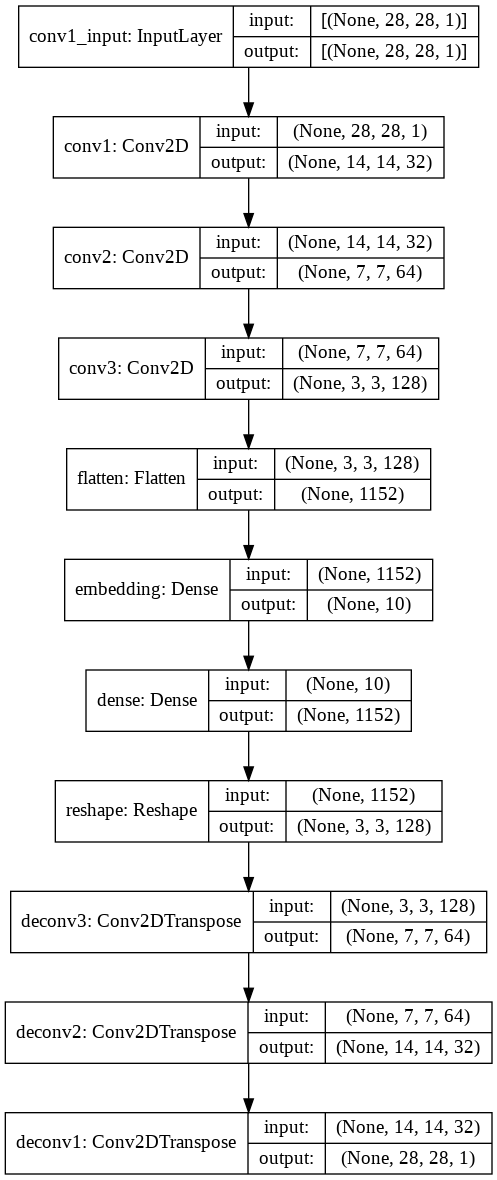

In [6]:
keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [13]:
optimizer = keras.optimizers.Adam()
loss = keras.losses.mean_squared_error
model.compile(optimizer=optimizer, loss= loss, metrics=["accuracy"])
model.fit(x, x, epochs=200)

Epoch 1/10
2188/2188 [==============================] - 8s 3ms/step - loss: 555.1836 - accuracy: 0.6803
Epoch 2/10
2188/2188 [==============================] - 7s 3ms/step - loss: 550.7731 - accuracy: 0.6776
Epoch 3/10
2188/2188 [==============================] - 8s 3ms/step - loss: 552.1410 - accuracy: 0.6789
Epoch 4/10
2188/2188 [==============================] - 8s 3ms/step - loss: 552.0702 - accuracy: 0.6788
Epoch 5/10
2188/2188 [==============================] - 8s 3ms/step - loss: 550.3200 - accuracy: 0.6786
Epoch 6/10
2188/2188 [==============================] - 8s 3ms/step - loss: 550.7201 - accuracy: 0.6781
Epoch 7/10
2188/2188 [==============================] - 8s 3ms/step - loss: 549.2510 - accuracy: 0.6781
Epoch 8/10
2188/2188 [==============================] - 7s 3ms/step - loss: 550.2976 - accuracy: 0.6778
Epoch 9/10
2188/2188 [==============================] - 7s 3ms/step - loss: 551.9680 - accuracy: 0.6781
Epoch 10/10
2188/2188 [==============================] - 8s 3ms/

# Finetune 

## Defining cluster layer

In [20]:
class ClusterLayer(layers.Layer):

  def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
    super(ClusterLayer, self).__init__(**kwargs)
    self.n_clusters = n_clusters
    self.alpha = alpha
    self.initial_weights = weights
    self.input_specs = layers.InputSpec(ndim=2)

  # Creating layers weights
  def build(self, input_shape):

    # input shape will be from embedding layer and it will be (batch size, 10)
    assert input_shape == 2

    input_dim = input_shape[1]
    self.input_spec = layers.InputSpec(shape=(None, input_dim))
    self.cluster = self.add_weight( name='clusters', shape=(self.n_clusters, input_dim), initializer='glorot_uniform'  )

    # Load initial weights if available
    if self.initial_weights is not None:
      self.set_weight(self.initial_weights)
      del self.initial_weights

    self.buit = True 

  def call(self, inputs, **kwargs):
    q = 1.0 / (1.0 + (keras.sum(keras.square(keras.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
    q **= (self.alpha + 1.0) / 2.0
    q = keras.transpose(keras.transpose(q) / keras.sum(q, axis=1))
    return q

In [22]:
model.save('model')

INFO:tensorflow:Assets written to: model/assets
